#  프로젝트: 한국어 데이터로 챗봇 만들기

#### 배경
- transformer 챗봇 모델을 만들어서 영어 데이터로 학습 후 예측 문장을 만들어봤다.
- 다른 언어인 한국어로 transformer 챗봇 모델을 만들어보자.

## Step 1. 데이터 수집하기

In [1]:
import tensorflow as tf
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print("슝=3")

슝=3


In [2]:
# 데이터 가져오기
path = os.getenv("HOME") + '/aiffel/transformer_chatbot/data/ChatbotData .csv'
df = pd.read_csv(path)
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [3]:
# label은 무엇을 뜻하는 것일까?
df['label'].value_counts()

0    5290
1    3570
2    2963
Name: label, dtype: int64

In [4]:
# label의 예를 보자
from IPython.display import display

display(df[df['label'] == 0][:7])
display(df[df['label'] == 1][:7])
display(df[df['label'] == 2][:7])

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0


,Q,A,label
5290,1000일 만난 여자친구와 이별,더 오래 만날 사람 만날 거예요.,1
5291,10년 연애. 헤어졌습니다.,더 공허함이 크시겠네요.,1
5292,10년 연애사 되돌아보니 다 부질없네,더 좋은 사람 만나실 거예요.,1
5293,10년 연예의끝,더 마음이 허하겠어요.,1
5294,10년만나다 헤어지네,충분히 슬퍼하고 충분히 아파하다가 이겨내세요.,1
5295,10년이라는 시간이 참 무색하다 싶네,함께 걸은 길을 혼자 돌아가고 계시겠네요.,1
5296,10월의 마지막밤 . 더 보고싶네 그사람,이별은 보고 싶은 마음을 참는 과정이죠.,1


,Q,A,label
8860,짝사랑만큼 고통스러운 건 없겠지.,짝사랑 만큼 감정소모가 큰 건 없을 거예요.,2
8861,1년 넘게 만났는데 지금도 불타올라,정열적인 사랑을 하고 있나봐요.,2
8862,1년 동거 중인데 계속 좋아,서로 깊게 알게되면서 더 좋아졌나봅니다.,2
8863,1년 동거하고 결혼했어,축하합니다!,2
8864,1년 만났는데도 그 사람에 대해 잘 모르겠어,더 만나보세요.,2
8865,1년반 만났는데 결혼하자고 해도 될까?,기다리고 있을지도 몰라요.,2
8866,1년째 동거중이야,서로 알아가는 단계인가봐요.,2


In [5]:
# 결측치 확인
df.isnull().sum()

Q        0
A        0
label    0
dtype: int64

In [6]:
# 데이터 전반적 개요 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


> #### note:
> - `label` 컬럼은 답변에 대한 카테고리로서 아래와 같다고 한다.(그런데 완전 fit한 것 같지는 않다.)
>   - 0 : 일상다반사
>   - 1 : 이별(부정)
>   - 2 : 사랑(긍정)
> - 데이터는 '사랑보다 아름다운 실연'이라는 다음 카페의 이야기를 참고하여 만든 인공 데이터라고 한다.
> - 그렇기에 주로 사랑, 그리고 그에 관한 위로에 관한 답변이 주를 이루는 것 같은데,
> - 하나 눈여겨 볼 점은 데이터가 **shuffle된 것 같지 않다.**(그러나 `tf.data.Dataset` 자료형으로 하고 shuffle을 하면 될 것 같다.)

## Step 2. 데이터 전처리하기
- punctuation은 띄어쓰기를 더해주고
- 한국어에 맞게 전처리되어야 할 부분은 없는지 고민해보자

q_lengths min : 1
q_lengths max : 15
q_lengths mean : 3.587414361837097
a_lengths min : 1
a_lengths max : 21
a_lengths mean : 3.6936479742874058


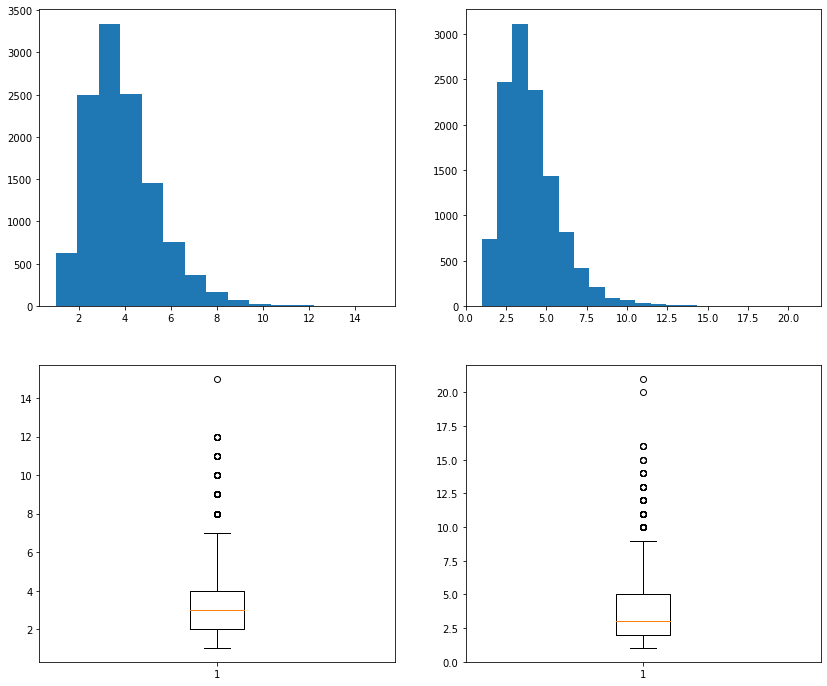

In [7]:
# 질문과 답변의 길이 확인
q_lengths = [len(sentence.split()) for sentence in df['Q']]
a_lengths = [len(sentence.split()) for sentence in df['A']]

print(f'q_lengths min : {min(q_lengths)}')
print(f'q_lengths max : {max(q_lengths)}')
print(f'q_lengths mean : {np.mean(q_lengths)}')
print('=============================')
print(f'a_lengths min : {min(a_lengths)}')
print(f'a_lengths max : {max(a_lengths)}')
print(f'a_lengths mean : {np.mean(a_lengths)}')

# 그래프로 분포 확인
plt.figure(figsize=(14, 12))
plt.subplot(2, 2, 1)
plt.hist(q_lengths, bins=15)
plt.subplot(2, 2, 2)
plt.hist(a_lengths, bins=21)
plt.subplot(2, 2, 3)
plt.boxplot(q_lengths)
plt.subplot(2, 2, 4)
plt.boxplot(a_lengths)

plt.show()

In [8]:
# 평균 길이(3개)를 갖는 문장들을 살짝 살펴보자
display(df[df['Q'].apply(lambda x : len(x)) == 3][:5])
display(df[df['A'].apply(lambda x : len(x)) == 3][:5])

,Q,A,label
89,개당황,다음부터는 더 많이 아세요.,0
93,개졸려,낮잠을 잠깐 자도 괜찮아요.,0
94,개좋아,저도 좋아해주세요.,0
118,건방져,기분이 나쁘셨나봐요.,0
123,겁난다,용기 내보세요.,0


,Q,A,label
2017,배에서 꾸룩꾸룩 소리 남,꼬르륵,0
2018,배에서 소리 남,꼬르륵,0
2366,새로운 마음으로,시작!,0
2367,새로운 마음으로 시작,시작!,0
3652,이 세상에서 누가 제일 예뻐,저요!,0


> #### note:
> - 원본 데이터의 전체 문장 쌍의 갯수는 11823개이고,
> - Q와 A 둘 다 약 3개 정도의 평균 문장 내 단어 개수를 보여준다.(굉장히 짧은 것들이 많다...)
> - 그리고 **중복된 답변**이 많은 것 같다.
> ##### 데이터도 살짝 적고 학습될 문장 자체도 살짝 적은 것 같다.(뭔가 있어도 최대한 데이터를 살리는 쪽으로 가야겠다.)

#### # punctuation 전처리

In [9]:
# punctuation이 별로 없는 것 같은데 있는지 확인해보자.
punctuations = [",", "'", ".", "?", "!", '"', "#", "%", ")"]

print('========================== \n Q 문장')
for punc in punctuations:
    print(f"{punc} 개수 : {df['Q'].apply(lambda x: punc in x).sum()}")

print('')
print('========================== \n A 문장')
for punc in punctuations:
    print(f"{punc} 개수 : {df['A'].apply(lambda x: punc in x).sum()}")


 Q 문장
, 개수 : 39
' 개수 : 2
. 개수 : 2148
? 개수 : 1705
! 개수 : 88
" 개수 : 0
# 개수 : 0
% 개수 : 2
) 개수 : 0

 A 문장
, 개수 : 36
' 개수 : 2
. 개수 : 11400
? 개수 : 94
! 개수 : 223
" 개수 : 0
# 개수 : 0
% 개수 : 0
) 개수 : 0


In [10]:
# '는 왜 있는 걸까?
display(df[df['Q'].apply(lambda x: "'" in x)])

# %는 왜 있는 걸까?
display(df[df['Q'].apply(lambda x: "%" in x)])

,Q,A,label
7318,윤종신 '좋니' 노래 가사가 엄청 와닿네,노래 가사가 공감이 많이 되네요.,1
9827,사귀는 사이인데 '야'라고 해. 기분 나쁜데 어떡해?,그건 좀 아닌 거 같다고 바로 말하세요.,2


,Q,A,label
2059,베터리 15%야,미리 충전하세요.,0
2060,베터리 겨우 15%야,미리 충전하세요.,0


In [11]:
# '와 %도 .과 마찬가지로 그냥 띄어쓰기를 해서 한 단어로만 인식하지 않게 해주면 되겠다.
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = re.sub(r"([?.!,'%])", r" \1 ", sentence) # punctuation과 단어 사이에 띄어쓰기를 넣어준다.
    sentence = sentence.strip() # 뒤에 공백 없도록 해준다.
    return sentence

In [12]:
# 새로운 컬럼으로 전처리되 값을 추가해준다.
df['pr_Q'] = df['Q'].apply(lambda x: preprocess_sentence(x))
df['pr_A'] = df['A'].apply(lambda x: preprocess_sentence(x))

df.head()

,Q,A,label,pr_Q,pr_A
0,12시 땡!,하루가 또 가네요.,0,12시 땡 !,하루가 또 가네요 .
1,1지망 학교 떨어졌어,위로해 드립니다.,0,1지망 학교 떨어졌어,위로해 드립니다 .
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .
4,PPL 심하네,눈살이 찌푸려지죠.,0,PPL 심하네,눈살이 찌푸려지죠 .


## Step 3. SubwordTextEncoder 사용하기

In [13]:
# tokenize할 때 Q, A 동시에 넣어줘야 하는데
# 동시에 넣기 쉽게 리스트화 해주기
q_list = list(df['pr_Q'])
a_list = list(df['pr_A'])

print(q_list[:5])
print('========================')
print(a_list[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


#### # 토큰화 진행

> #### note:
> - 개인적으로 여태까지 진행했던 NLP 프로젝트 경험상 학습 시간에 비해 제대로 된 문장이 출력된 적이 별로 없었는데, `vocabulary`나 `임베딩 벡터`가 애초에 좋아야겠다라는 생각을 많이 했었다.
> - 이번에는 토큰화하는 단어사전의 target_vocab_size 파라미터로 약 16000개로 넣어볼 예정이다(실습 때는 약 8000개)

In [14]:
import tensorflow_datasets as tfds

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(q_list + a_list, target_vocab_size=2**14)

In [15]:
# 시작 토큰과 종료 토큰에 고유한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print(f'토큰화된 마지막 단어 번호 : {tokenizer.vocab_size-1}')
print(f'START_TOKEN의 번호 : {START_TOKEN}')
print(f'END_TOKEN의 번호   : {END_TOKEN}')

토큰화된 마지막 단어 번호 : 21862
START_TOKEN의 번호 : [21863]
END_TOKEN의 번호   : [21864]


In [16]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기 산정
VOCAB_SIZE = tokenizer.vocab_size + 2

# 문장의 최대 길이를 정하다.
# 데이터가 굉장히 적다.
# 그래서 다 살리는 것이 낫다.
# 그래서 그냥 65으로 정했다.
# 전처리된 후의 max 문장 길이를 뽑아보자.
q_lengths_after = [len(sentence.split()) for sentence in df['pr_Q']]
a_lengths_after = [len(sentence.split()) for sentence in df['pr_A']]

# 둘 중에 가장 긴 것으로 정한다.
MAXLEN = max(max(q_lengths_after), max(a_lengths_after))

# 그리고 START_TOKEN과 ENDTOKEN이 들어갈 것이니 2를 더해준다.
MAXLEN = MAXLEN +2
print(VOCAB_SIZE)
print(MAXLEN)

21865
26


#### # 정수 인코딩 & 패딩하기

In [17]:
# 현재 tokenizer에는 질문, 답변의 단어들이 정수로 토큰화되어 있다.
# 정수 인코딩 잘 되는지 확인
print('원문 :', q_list[1])
print('인코딩 :', tokenizer.encode(q_list[1]))
print('디코딩 :', tokenizer.decode(tokenizer.encode(q_list[1])))

원문 : 1지망 학교 떨어졌어
인코딩 : [21540, 580, 1066]
디코딩 : 1지망 학교 떨어졌어


In [18]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩하는 함수 정의
def tokenize_and_filter(inputs_1, inputs_2):
    tokenized_inputs_1, tokenized_inputs_2 = [], []
  
    for (sentence1, sentence2) in zip(inputs_1, inputs_2):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        # 인코딩 결과가 리스트임
        # START_TOKEN, END_TOKEN도 리스트인 상태여서 '+'로 붙일 수 있음
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAXLEN and len(sentence2) <= MAXLEN:
            tokenized_inputs_1.append(sentence1)
            tokenized_inputs_2.append(sentence2)
  
    # 최대 길이에 맞춰 모든 데이터셋을 패딩
    tokenized_inputs_1 = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs_1, maxlen=MAXLEN, padding='post')
    tokenized_inputs_2 = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs_2, maxlen=MAXLEN, padding='post')
  
    return tokenized_inputs_1, tokenized_inputs_2

> - MAXLEN에 맞춰서 제외된 데이터가 있을 테니 `tokenize_and_filter()` 진행 후 데이터 개수 재확인

In [19]:
questions, answers = tokenize_and_filter(q_list, a_list)

print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 전의 데이터 개수: {}'.format(len(df)))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 21865
필터링 전의 데이터 개수: 11823
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [20]:
# 패딩됐는지 확인해보기
print(questions[0])
print(answers[0])

[21863 21576 18404    24 21864     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
[21863  2038    44  3869     1 21864     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


#### # 데이터셋화( + 교사 강요를 위한 전처리)

In [21]:
BATCH_SIZE = 64
BUFFER_SIZE = len(questions)

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


In [22]:
print(dataset)

<PrefetchDataset shapes: ({inputs: (None, 26), dec_inputs: (None, 25)}, {outputs: (None, 25)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>


> #### note:
> - 각각의 shape을 통해 데이터가 잘 묶인 것을 확인할 수 있다.

## Step 4. 모델 구성하기

#### # 모델 구현에 필요한  함수 정의
- scaled_dot_product_attention
- padding_mask
- look_ahead_mask

In [23]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True) #Q와 K가 모양이 같으니까 transpose_b를 통해 K 행렬을 전치시킴

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

print("슝=3")

슝=3


In [24]:
# 패딩 마스킹을 구현한 함수
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [25]:
# 실험해보기
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


> #### note:
> - 위와 같이 **0**으로 패딩된 곳은 1로 바뀌고, 아닌 **일반** 정수는 0으로 바뀌는, 즉 마스킹 해야할 부분을 1로 만들어주는 함수인 듯하다.

In [26]:
# 룩 어헤드 마스크 구현하기
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


> - 이게 어떤 일을 하는지 확인해보자!

In [27]:
# 실험
test_tf = tf.constant([[ 0,  1,  2, 3],
 [-1,  0,  1, 2],
 [-2, -1,  0, 1],
 [-3, -2, -1, 0]],)

test_tf

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[ 0,  1,  2,  3],
       [-1,  0,  1,  2],
       [-2, -1,  0,  1],
       [-3, -2, -1,  0]], dtype=int32)>

In [28]:
# 실험
tf.linalg.band_part(test_tf, -1, 0)

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[ 0,  0,  0,  0],
       [-1,  0,  0,  0],
       [-2, -1,  0,  0],
       [-3, -2, -1,  0]], dtype=int32)>

In [29]:
# 실험
1 - tf.linalg.band_part(test_tf, -1, 0)

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[1, 1, 1, 1],
       [2, 1, 1, 1],
       [3, 2, 1, 1],
       [4, 3, 2, 1]], dtype=int32)>

In [30]:
# 실험
tf.linalg.band_part(test_tf, 0, -3)

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[0, 1, 2, 3],
       [0, 0, 1, 2],
       [0, 0, 0, 1],
       [0, 0, 0, 0]], dtype=int32)>

> #### note:
> - `tf.linalg.band_part()` 함수를 이해할 수 있는 쉬운 설명을 못 찾아서 정확히 이해는 안되지만,
> - `num_lower`(두번째 인자)와 `num_upper`(세번째 인자) 사이의 값이 아닌 것들은 0으로 만들어 버린단다.
> - 근데 이게 약간 upper right corner 쪽만 그렇게 하려는 것 같다.
> - 그래서 이 경우엔 문장 내 아직 보면 안되는 단어들을 일단 0으로 만들어주고,
> - 나머지 수는 음수로 만들어준다.
> - 그리고 0으로 된 것들(패딩 포함)은 다시 1로 바꾸는 과정을 해서 결국에 **내가 보고 싶은 건 음수, 가려야 하는 건 1**로 만들어서
> - 그 1인 것들이 마스킹 되게끔 하는 것 같다.

#### # 모델 구현에 필요한 레이어(subclassing) 및 모델 생성 함수 만들기
- Positional Encoding
- Multi-Head Attention
- 인코더 레이어 연결 함수
- 인코더 층 쌓기 함수
- 디코더 레이어 연결 함수
- 디코더 층 쌓기 함수
- ##### 하나로 합친 트랜스포머 모델 생성 함수

In [31]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


In [32]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
    
        assert d_model % self.num_heads == 0
    
        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs
print("슝=3")

슝=3


In [33]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
           'mask': padding_mask
        })
    
    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [34]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
          inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [35]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)
print("슝=3")

슝=3


In [36]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)
print("슝=3")

슝=3


In [37]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


#### # 모델 생성 및 컴파일

In [38]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    14350848    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [39]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAXLEN - 1)) 
    # 여기 MAXLEN -1을 해주는 이유는 결과 값에서 START_TOKEN 없는 거로 훈련 돼서 나오니까
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)
print("슝=3")

슝=3


In [40]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

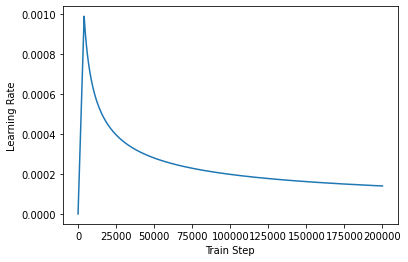

In [41]:
# 시각화해보기
sample_learning_rate = CustomSchedule(d_model=256)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [42]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
      learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAXLEN - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [43]:
EPOCHS = 40
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/40
185/185 [==============================] - 51s 235ms/step - loss: 2.1678 - accuracy: 0.0285
Epoch 2/40
185/185 [==============================] - 43s 233ms/step - loss: 1.5722 - accuracy: 0.0771
Epoch 3/40
185/185 [==============================] - 43s 233ms/step - loss: 1.2707 - accuracy: 0.0781
Epoch 4/40
185/185 [==============================] - 43s 234ms/step - loss: 1.1603 - accuracy: 0.0830
Epoch 5/40
185/185 [==============================] - 43s 232ms/step - loss: 1.0812 - accuracy: 0.0872
Epoch 6/40
185/185 [==============================] - 43s 232ms/step - loss: 0.9858 - accuracy: 0.0934
Epoch 7/40
185/185 [==============================] - 43s 231ms/step - loss: 0.8840 - accuracy: 0.1035
Epoch 8/40
185/185 [==============================] - 43s 234ms/step - loss: 0.7691 - accuracy: 0.1187
Epoch 9/40
185/185 [==============================] - 43s 235ms/step - loss: 0.6300 - accuracy: 0.1346
Epoch 10/40
185/185 [==============================] - 43s 232ms/step - l

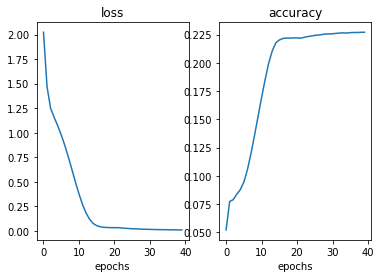

In [44]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='train loss')
plt.title('loss')
plt.xlabel('epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='train accuracy')
plt.title('accuracy')
plt.xlabel('epochs')

plt.show()

#### Step 5. 모델 평가하기

In [45]:
# 위의 과정을 모두 담은 decoder_inference() 함수 선언
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAXLEN):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [46]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
          [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence
print("슝=3")

슝=3


In [47]:
sentence_generation('오늘은 좀 힘든 날이었어')

입력 : 오늘은 좀 힘든 날이었어
출력 : 공부 도와달라고 해보세요 .


'공부 도와달라고 해보세요 .'

In [48]:
sentence_generation('어디 놀러가볼까?')

입력 : 어디 놀러가볼까?
출력 : 달라지는게 없다면 지금이 좋을지도 몰라요 .


'달라지는게 없다면 지금이 좋을지도 몰라요 .'

In [49]:
sentence_generation('사랑한다 말해줘!')

입력 : 사랑한다 말해줘!
출력 : 마음의 정리가 끝났길 바랍니다 .


'마음의 정리가 끝났길 바랍니다 .'

In [50]:
sentence_generation('카페 갈까?')

입력 : 카페 갈까?
출력 : 카페 데이트 좋죠 .


'카페 데이트 좋죠 .'

In [51]:
sentence_generation('$%**')

입력 : $%**
출력 : 사랑의 빠르게 흘러 가죠 .


'사랑의 빠르게 흘러 가죠 .'

In [52]:
sentence_generation('어디 카페가 좋아?')

입력 : 어디 카페가 좋아?
출력 : 연락 안되면 걱정된다고 꼭 중간중간 연락 달라고 해보세요 .


'연락 안되면 걱정된다고 꼭 중간중간 연락 달라고 해보세요 .'

In [53]:
sentence_generation('12시 땡!')

입력 : 12시 땡!
출력 : 하루가 또 가네요 .


'하루가 또 가네요 .'

#### 결론 : 약간은 미숙한 응답들이 많다.

## 회고
#### Point 1) 한국어 전처리 및 예측
- 영어 전처리만 보다가 한국어 전처리하려니까 많은 부분이 다르다.
- 일단 사용하는 punctuation이 살짝 다르고(한국말에서는 소유격을 잘 안 쓴다)
- 그리고 대문자도 없다는 점이 어쩌면 더 단순한 것 같으면서도 뭔가 빼먹은 듯한 느낌을 준다...
- 실습 시 영어 문장 대답은 별 기대를 안했는데 한국어는 좋은 예측이 나오길 많이 기대했다.(그래서 `d_model`도 512로 올렸다.)
- 그리고 결과를 봤는데 정말 간단한 문장 혹은 훈련 데이터와 정확히 맞아떨어지는 것들만 그럭저럭 괜찮은 답변이 온 것 같다.
  - 입력 : `카페 갈까?` 출력 : `카페 데이트 좋죠 .`
- 설명 보니까 BERT도 1달 동안 훈련시킨 거라고 하니까 어쩌면 현재 학습하는 수준에서는 이 정도 성과가 기대할 수 있는 수준인 것 같다.

#### Point 2) `len(string)`, `len(list)`는 다르다...
- 한 문장 내 '단어'의 갯수를 확인하는 게 우리는 중요하다.
- 왜냐하면 그것에 따라 패딩할 때 `MAX_LENGTH`를 지정해주는 것이니..
- 그런데 아래와 같이 코드 하니 밑의 그래프와 같은 결과가 나왔다.
```python
q_lengths = [len(sentence) for sentence in df['Q']]
a_lengths = [len(sentence) for sentence in df['A']]
```
![](https://images.velog.io/images/moondeokjong/post/de6a608a-51be-4560-8133-b70b15f6c4a1/Screenshot%202022-02-17%20at%203.52.42%20PM.png)
- 그리고 이것이 문제되는 줄도 모르고 패딩하다가 전처리가 잘됐는지 확인하는 '습관'을 실행하던 중 알게됐다.
- 내가 당시 정한 `MAX_LENGTH`(65) 덕분에 아무 데이터도 제외되지 않았음을...(물론 나중엔 데이터가 적어서 일부러 다 포함하려 하긴 했지만...)
- 그리고 다시 확인해 보니 맥시멈으로서 76개의 len을 가졌다던 그 문장은 실은 아래의 문장이었다.
```python
10808    연애는 문제가 있으면 문제를 해결 하기 위해 함께 노력하고 그 속에서 더욱 단단해지...
Name: A, dtype: object
```
- 시각화가 아닌 텍스트로 이루어지는 프로그래밍에서는 내가 실행한 것과 그것의 결과를 확인하는 습관이 참 중요한 것 같다...

#### Point 3) 갈수록 어려워지는 LMS 노드...
- 저번주 언젠가를 기점으로 한번에 이해하기 어려운 개념과 코드들이 많이 등장하고 있다.
- 그런데 해커톤 같은 건 실제 적용스럽게 하려면 더 어려울 텐데...
- 이럴 때일수록 건강한 정신이 더 중요해지는 것 같다.
- 욕심 부리지 말고 내 페이스에 맞게 오래오래 행복하게 공부하려던 초심을 잃지 말자